In [402]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [547]:
import numpy as np
import pandas as pd 
from fastai.vision.all import * 
from fastai.metrics import accuracy
from PIL import Image
from PIL import ImageFile 
import matplotlib.pyplot as plt 
import torch 
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm 
from IPython.display import clear_output 
import warnings 
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns

warnings.filterwarnings("ignore")

In [404]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [405]:
data_path = Path(r'C:\Users\Acer\Desktop\test\Mushrooms')

In [406]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [407]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [408]:
def load_images_to_memory(data_path):
    images = []
    labels = []
    for folder_name in os.listdir(data_path):
        folder_path = data_path / folder_name
        for img_name in os.listdir(folder_path):
            img_path = folder_path / img_name
            clear_output()
            print(img_path)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((96, 96))
            img = np.array(img)
            images.append(img)
            labels.append(folder_name)
    return np.array(images), np.array(labels)

In [409]:
images, labels = load_images_to_memory(data_path)
images = images / 255.0

C:\Users\Acer\Desktop\test\Mushrooms\Suillus\336_ujDTEEWsRc8.jpg


In [410]:
images

array([[[[0.11372549, 0.09803922, 0.09019608],
         [0.10588235, 0.08627451, 0.08235294],
         [0.19607843, 0.16862745, 0.16078431],
         ...,
         [0.01568627, 0.00392157, 0.        ],
         [0.02352941, 0.00392157, 0.        ],
         [0.01568627, 0.00784314, 0.00392157]],

        [[0.1254902 , 0.10980392, 0.09411765],
         [0.18039216, 0.16470588, 0.14901961],
         [0.14509804, 0.13333333, 0.12156863],
         ...,
         [0.03137255, 0.00392157, 0.00392157],
         [0.04705882, 0.00784314, 0.01176471],
         [0.04313725, 0.00784314, 0.01176471]],

        [[0.11372549, 0.10196078, 0.07843137],
         [0.2       , 0.18823529, 0.16862745],
         [0.13333333, 0.12941176, 0.10980392],
         ...,
         [0.04705882, 0.01176471, 0.01568627],
         [0.05882353, 0.01568627, 0.02352941],
         [0.04313725, 0.00784314, 0.00784314]],

        ...,

        [[0.02352941, 0.00784314, 0.00784314],
         [0.02352941, 0.01176471, 0.00392157]

In [411]:
np.random.seed(3)

In [ ]:

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

label_encoder = LabelEncoder()
e_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(images, e_labels, test_size=0.2, random_state=42)

print
def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    #tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y)
    return dataset

train_dataset = get_dataset(X_train, y_train)
test_dataset = get_dataset(X_test, y_test)

In [413]:

del images

In [414]:
print(len(train_dataset))
print(len(test_dataset))

5371
1343


In [415]:
class_names = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


Original shape is  torch.Size([96, 96, 3])


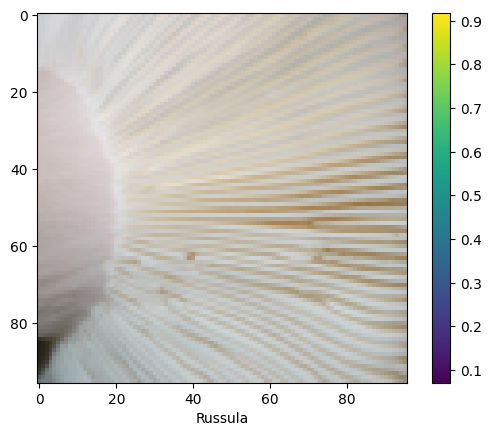

In [416]:
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

In [417]:
print('Original shape is:', images_data[0].shape)  # [C, H, W]


Original shape is: torch.Size([96, 96, 3])


In [446]:
def build_alexnet():
    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 96x96x3 (RGB Image)
        torch.nn.Conv2d(3, 96, 11, stride=4, padding=2),  # out: 24x24x96
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),  # out: 11x11x96
        
        torch.nn.Conv2d(96, 256, 5, padding=2),  # out: 11x11x256
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),  # out: 5x5x256
        
        torch.nn.Conv2d(256, 384, 3, padding=1),  # out: 5x5x384
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(384, 384, 3, padding=1),  # out: 5x5x384
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(384, 256, 3, padding=1),  # out: 5x5x256
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),  # out: 2x2x256
        
        torch.nn.Flatten(),
        
        torch.nn.Linear(2*2*256, 4096),  # fully connected layer 1
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        
        torch.nn.Linear(4096, 4096),  # fully connected layer 2
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        
        torch.nn.Linear(4096, 10)  # fully connected layer 3 (output layer, 10 classes)
    )

    net.apply(init_weights)
    return net

In [447]:
net = build_alexnet()
net.to(device)
print(net)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

In [ ]:
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history

In [449]:
BATCH_SIZE = 16
EPOCHS = 31
LR = 0.0023907002927538432

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist_net = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 30, Batch: 335, Loss: 58.10, Acc: 0.91: 100%|██████████| 10416/10416 [02:44<00:00, 63.41it/s]


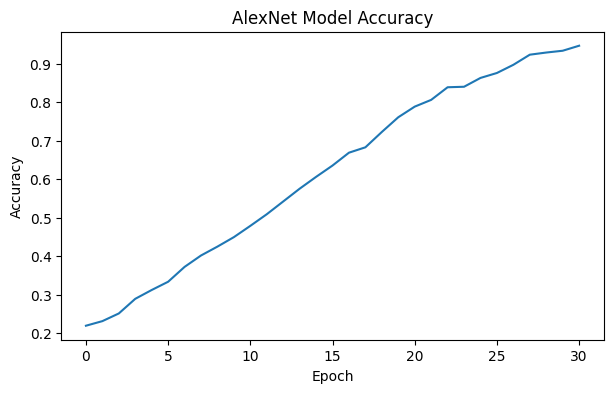

In [450]:
print_history(hist_net, "AlexNet Model Accuracy")

In [554]:
def evaluate_acc(net, test_loader, device):
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    for _, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    
    acc = correct / total
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return acc

In [555]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

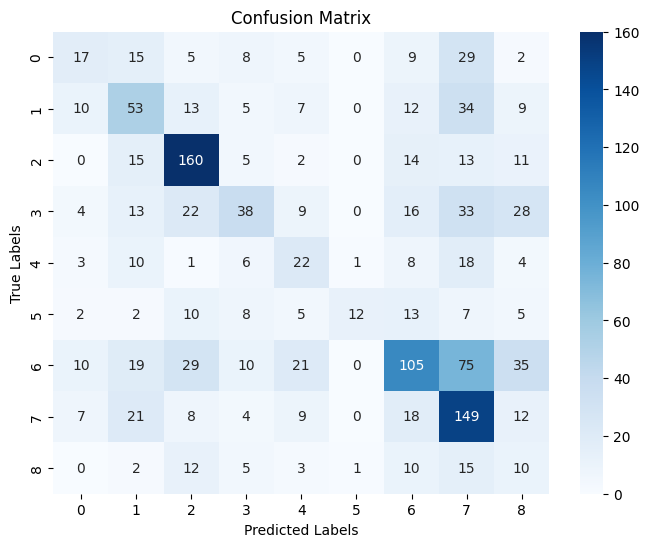

Test Accuracy (LeNet): 42.14%


In [556]:
lenet_acc = evaluate_acc(net, test_dataloader, device)

print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))

### HYPERPARAMS

In [ ]:
def objective(trial):
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    EPOCHS = trial.suggest_int("epochs", 30, 50)
    LR = trial.suggest_loguniform("lr", 0.001, 0.005)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    model = net.to(device)
    hist_net = train(model, train_dataloader, device, EPOCHS, LR)

    val_accuracy = hist_net[-1]
    
    return 1.0 - val_accuracy

#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=3)
#
#print("Best hyperparameters:", study.best_params)
#Best hyperparameters: {'batch_size': 16, 'epochs': 31, 'lr': 0.0023907002927538432}

[I 2024-11-15 19:00:54,551] A new study created in memory with name: no-name-0d8da7a9-980d-40ff-ac2d-3daf70152357
Epoch: 30, Batch: 335, Loss: 12.29, Acc: 1.00: 100%|██████████| 10416/10416 [02:45<00:00, 63.10it/s]
[I 2024-11-15 19:03:39,628] Trial 0 finished with value: 0.011171104077453031 and parameters: {'batch_size': 16, 'epochs': 31, 'lr': 0.0023907002927538432}. Best is trial 0 with value: 0.011171104077453031.
Epoch: 40, Batch: 167, Loss: 0.00, Acc: 1.00: 100%|██████████| 6888/6888 [02:23<00:00, 47.86it/s]
[I 2024-11-15 19:06:03,562] Trial 1 finished with value: 0.0 and parameters: {'batch_size': 32, 'epochs': 41, 'lr': 0.004400756527256192}. Best is trial 0 with value: 0.011171104077453031.
Epoch: 34, Batch: 167, Loss: 0.00, Acc: 1.00: 100%|██████████| 5880/5880 [02:02<00:00, 47.90it/s]
[I 2024-11-15 19:08:06,312] Trial 2 finished with value: 0.0 and parameters: {'batch_size': 32, 'epochs': 35, 'lr': 0.0017291891764111898}. Best is trial 0 with value: 0.011171104077453031.


Best hyperparameters: {'batch_size': 16, 'epochs': 31, 'lr': 0.0023907002927538432}


In [520]:
def show_random(net, dataloader, train_image_no):
    def get_prediction(net, input):
        input = input.to(device)
        outputs = net(input)        
        _, predicted = outputs.max(1)
        return predicted

    images_data, original_label = next(iter(dataloader))
    images_data = images_data[train_image_no]
    original_label = original_label[train_image_no]

    print("images_data shape:", images_data.shape)

    if len(images_data.shape) == 3:  # if no batch dimension, add it
        images_data = images_data.unsqueeze(0) 
    
    images_data = images_data.permute(0, 3, 1, 2)

    predicted_label = get_prediction(net, images_data)
    print('original_label ', original_label) 
    print('predicted_label ', predicted_label)
    c = 'green' if original_label == predicted_label[0] else 'red'

    plt.figure()
    plt.imshow(images_data[0].cpu().numpy().transpose(1, 2, 0))
    plt.colorbar()
    plt.xlabel(class_names[predicted_label], color=c)
    plt.show()


images_data shape: torch.Size([96, 96, 3])
original_label  tensor(7)
predicted_label  tensor([7], device='cuda:0')


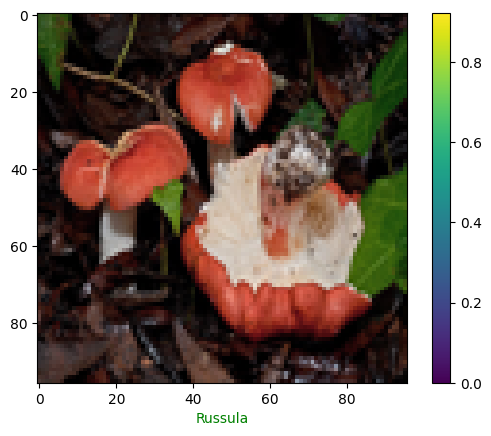

In [545]:
#nn
show_random(net, test_dataloader, random.randint(0,10))